In [1]:
import pandas as pd
from sodapy import Socrata

#socrata shit connects to the API endpoint
#first string here is the link ig
#second string is our personal access token so there's no throttle on api requests
with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:
    #gets the taxi zones (the geometry of each zone in the city + the zone name and borough)
    taxi_zones =  pd.DataFrame.from_records(client.get('755u-8jsi'))
    
    #gets some sample data from the high volume pickup/dropoff dataset, its not a random sample though
    #HV0003 corresponds to Uber
#     high_volume_query_results = client.get('yrt9-58g8', limit = 5000, where = 'hvfhs_license_num = "HV0003"')
#     trip_sample = pd.DataFrame.from_records(high_volume_query_results)

In [2]:
#some friendly transformations
#datetime values to dt format
#numbers to ints
taxi_zones.location_id = taxi_zones.location_id.astype(int)

def cleanup_func(trip_df):
    tdf = trip_df.copy()
    tdf.pulocationid = tdf.pulocationid.astype(int)
    tdf.dolocationid = tdf.dolocationid.astype(int)
    tdf.pickup_datetime = pd.to_datetime(tdf.pickup_datetime)
    tdf.dropoff_datetime = pd.to_datetime(tdf.dropoff_datetime)
    return tdf

# trip_sample = cleanup_func(trip_sample)
# trip_sample.head(1)

In [3]:
import numpy as np

taxi_zones

,objectid,shape_leng,the_geom,shape_area,zone,location_id,borough
0,1,0.116357453189,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.0007823067885,Newark Airport,1,EWR
1,2,0.43346966679,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.00486634037837,Jamaica Bay,2,Queens
2,3,0.0843411059012,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000314414156821,Allerton/Pelham Gardens,3,Bronx
3,4,0.0435665270921,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000111871946192,Alphabet City,4,Manhattan
4,5,0.0921464898574,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000497957489363,Arden Heights,5,Staten Island
...,...,...,...,...,...,...,...
258,256,0.0679149669603,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000168611097013,Williamsburg (South Side),256,Brooklyn
259,259,0.126750305191,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000394552487366,Woodlawn/Wakefield,259,Bronx
260,260,0.133514154636,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.000422345326907,Woodside,260,Queens
261,261,0.0271204563616,"{'type': 'MultiPolygon', 'coordinates': [[[[-7...",0.0000343423231652,World Trade Center,261,Manhattan


In [4]:
def add_polygons(lists, poly_list, region_id):
    
    if len(lists) > 1 and np.array([len(l) == 2 for l in lists]).all():
        poly_list.append([lists, region_id])
    else:
        for l in lists:
            add_polygons(l, poly_list, region_id)

def merc_from_arrays(lats, lons):
    r_major = 6378137.000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return np.c_[x, y]

polygons = []
for i,z in taxi_zones.iterrows():
    p = z['the_geom']['coordinates']
    
    add_polygons(p, polygons, z.location_id)
    
coords = np.concatenate([p[0] for p in polygons])

mercs = merc_from_arrays(coords[:,1], coords[:,0])

In [5]:
def convert_latlon_polygon_coords(polygon_coords, left, top, bbox_length, bbox_width):

    p = np.array(polygon_coords[0])
    merc = merc_from_arrays(p[:,1], p[:,0])
    
    return np.c_[np.abs(merc[:,0] - left) / bbox_length, 
                 np.abs(top - merc[:,1]) / bbox_width]

left, bottom, right, top = mercs[:,0].argmin(), mercs[:,1].argmin(), mercs[:,0].argmax(), mercs[:,1].argmax()
d_x = np.abs(mercs[left] - mercs[right])[0]
d_y = np.abs(mercs[top] - mercs[bottom])[1]

In [8]:
from joblib import load

dmovements = load('viz/sample_driver_movements_1_day')

In [12]:
total_movements = 0
for k, v in dmovements.items():
    total_movements += len(v)
total_movements

914473

In [22]:
start_pos = dmovements[0][0]

(0, 3.0, -1)

In [23]:
list(dmovements[0])[1:]

[(363.77770734026956, -185.0, 59220),
 (371.9856580641057, 185, -1),
 (506.8219065033323, -213.0, 100295),
 (509.53459222428546, 213, -1),
 (544.0804468601307, -213.0, 114951),
 (547.3489823699389, 213, -1),
 (596.6553894663328, -159.0, 133797),
 (612.3193951840548, 159, -1),
 (828.4729206187062, -147.0, 208125),
 (841.6966914568202, 147, -1),
 (871.509955725973, -248.0, 223387),
 (885.1828956322541, 248, -1),
 (894.8879385788555, -78.0, 231857),
 (928.0540756488798, 78, -1),
 (971.3943155606371, -41.0, 260562),
 (989.0007812572929, 41, -1),
 (1047.1115009567536, -209.0, 291123),
 (1048.4632050399798, 209, -1),
 (1052.4320752662618, -237.0, 293532),
 (1062.1713275797044, 237, -1),
 (1062.5068065184028, -142.0, 297986),
 (1071.3710515286389, 142, -1),
 (1164.7727534615262, -237.0, 345594),
 (1175.5422658956986, -141.0, 345882),
 (1186.1893122770227, -162.0, 353158),
 (1195.0187132296344, 162, -1),
 (1195.22924137643, -79.0, 359799),
 (1257.0187253141316, 79, -1),
 (1257.5156896708484, -

In [28]:
#transforms list of driver movements to format ((zstart,zend), (tstart, tend), p) 
#where z = zone id and t = time of destination, p = passenger
def extract_movement_information(dmovements, starting_position):
    current_position = starting_position[1]
    current_time = starting_position[0]
    movement_list = []
    
    i = 0
    while i < len(dmovements):
        #list starts off with a movement
        current_time = dmovements[i][0]
        
        next_position = dmovements[i][1] * -1
        next_time = dmovements[i + 1][0]
        movement_list.append((
                              (current_position, next_position),
                              (current_time, next_time),
                              dmovements[i][2]
                             )
                            )
        current_position = next_position
        
        if dmovements[i + 1][1] < 0:
            i += 1
        else:
            i += 2
    return movement_list

j = 2
extract_movement_information(list(dmovements[j])[1:], dmovements[j][0])

[((3.0, 18.0), (380.8007326082675, 390.16957518553596), 62498),
 ((18.0, 169.0), (420.20016697899507, 424.17628118791197), 70325),
 ((169.0, 167.0), (441.57314649667194, 481.21481038340494), 77258),
 ((167.0, 168.0), (551.0049915815006, 552.2405700467675), 117370),
 ((168.0, 119.0), (714.207070832674, 742.3356673706141), 170422),
 ((119.0, 151.0), (745.6624214206747, 752.2222124458743), 180351),
 ((151.0, 173.0), (753.6620202574636, 799.4097681643386), 182936),
 ((173.0, 138.0), (800.6005733639336, 806.7771246281119), 198635),
 ((138.0, 170.0), (972.7684883205206, 988.7245088836582), 261083),
 ((170.0, 42.0), (999.0457249136399, 1013.4039406290318), 271283),
 ((42.0, 159.0), (1013.4756510969331, 1013.4891359085391), 276741),
 ((159.0, 47.0), (1092.651422726216, 1100.4342183111012), 311584),
 ((47.0, 59.0), (1111.2208135468122, 1122.4708799453979), 320353),
 ((59.0, 60.0), (1132.8298695291487, 1136.9562619087321), 330693),
 ((60.0, 60.0), (1165.545310549191, 1169.379010720493), 345970),

<AxesSubplot:ylabel='Count'>

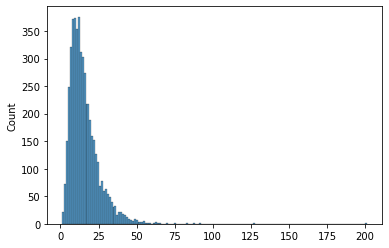

In [3]:
import seaborn as sns

#trip length distribution in minutes

#we can pretty easily get the average time it takes to get from one zone to another zone every day (with enough data)
trip_lengths = (trip_sample.dropoff_datetime - trip_sample.pickup_datetime).dt.seconds / 60
sns.histplot(trip_lengths)

In [4]:
import time

t1 = time.time()

with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:
    
    #get a bunch of records (10M)
    #HV0003 corresponds to Uber
    high_volume_query_results = client.get('yrt9-58g8', limit = 1000000, where = 'hvfhs_license_num = "HV0003"')
    trips = cleanup_func(pd.DataFrame.from_records(high_volume_query_results))
    
t2 = time.time()
print('time elapsed for query: ',t2 - t1)

KeyboardInterrupt: 

In [ ]:
#each entry is how many times someone traveled from region to region (row -> column)
travel_between_regions = pd.crosstab(index = trips['pulocationid'], columns = trips['dolocationid'])
travel_between_regions = travel_between_regions.sort_index(axis=0).sort_index(axis=1)
travel_between_regions

In [23]:
travel_between_regions.shape #missing a few regions in pickups and dropoffs with 1mill records

(258, 260)

In [20]:
#percentage of region -> region that is described by the data 
(travel_between_regions == 0).values.mean()

0.36933512224209897

Zone, borough:  244    Yorkville West
Name: zone, dtype: object 244    Manhattan
Name: borough, dtype: object


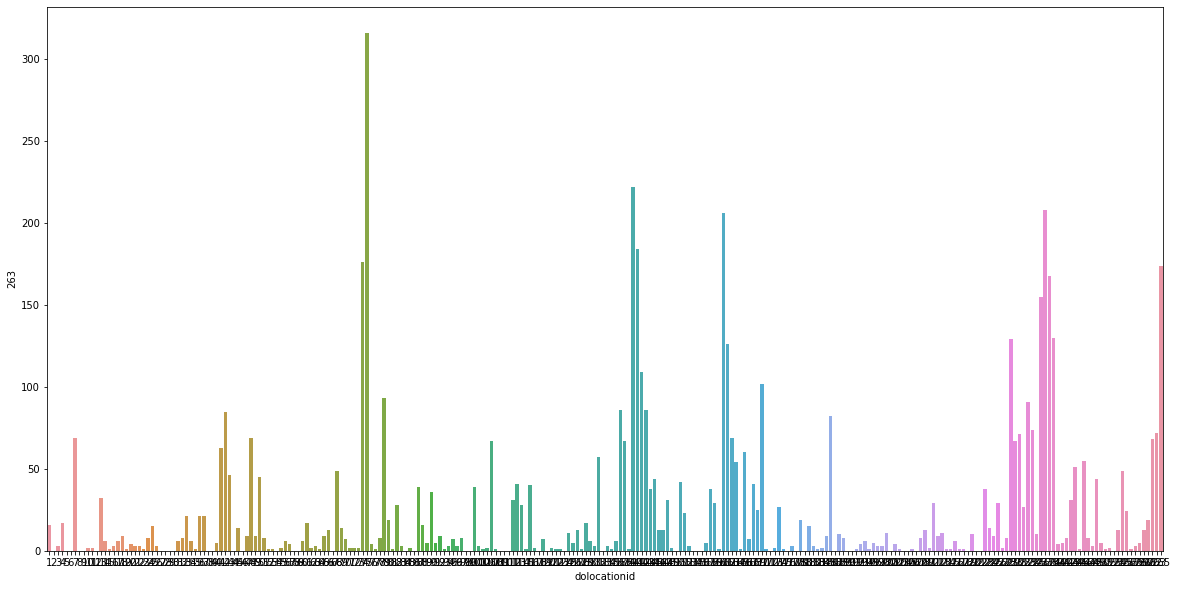

In [44]:
from matplotlib import pyplot as plt

#distribution of dropoffs for 1 pickup region 
region_id = 263
sample_pu_region = taxi_zones[taxi_zones.location_id == region_id]
pu_region_do_dist = travel_between_regions.loc[region_id]
print('Zone, borough: ', sample_pu_region.zone, sample_pu_region.borough)

plt.figure(figsize=(20,10))
g  = sns.barplot(x = pu_region_do_dist.index, y = pu_region_do_dist)

<AxesSubplot:>

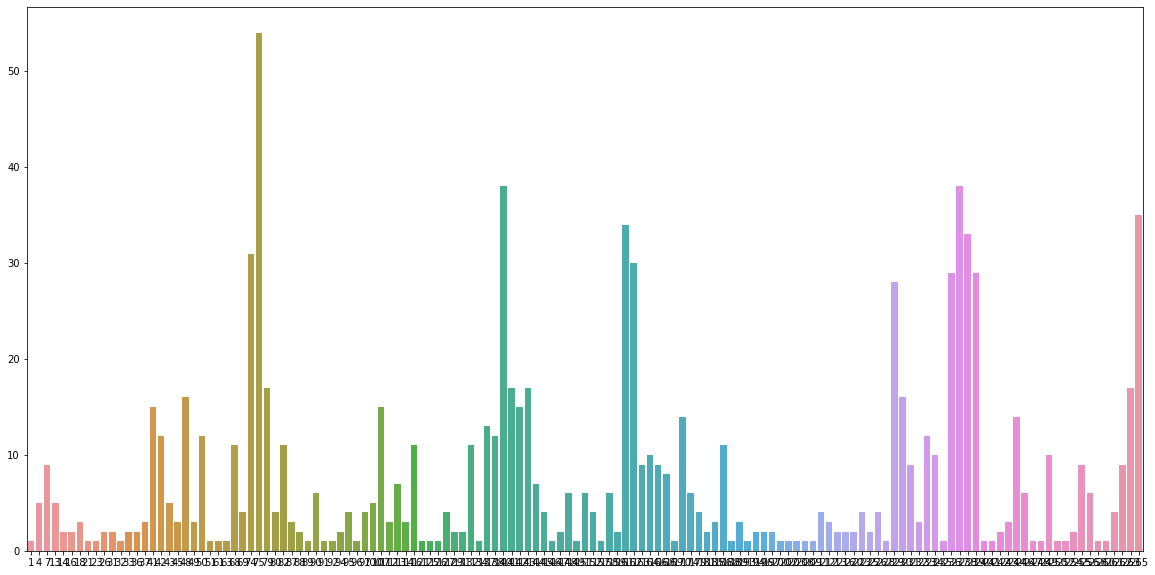

In [43]:
import numpy as np

#sample dropoffs for 1k pickups in this region:
#experience a little bit of vanishing regions because of low probabilities
#only a problem if those regions have vastly different travel times
sample_dos = np.random.choice(pu_region_do_dist.index, 
                              size = 1000, 
                              p = pu_region_do_dist / pu_region_do_dist.sum())
i, c = np.unique(sample_dos, return_counts = True)

plt.figure(figsize=(20,10))
sns.barplot(x = i, y = c)